# Beyond Talent: Unveiling the Hidden Factors Behind an Actor's Success
## CMU Movies Summary Corpus
- Authors: Zaynab, Lylia, Ali, Christian, Yassin
---
---

## Table of Contents
- [1. Actors dataset creation](##1.-Actors-dataset-creation )
- [2. Lylia's part](##2.-Lylia's-part)
- [3. Ali's part](##3.-Ali's-part)
- [4. Cristians's part](##4.-Christian's-part)
- [5. Network Analysis](##5.-Network-Analysis)

---
## Library import

In [9]:
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import networkx as nx
import seaborn as sns
import numpy as np
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools
from collections import Counter

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

---
## 1. Actors dataset creation 

### Loading datasets

* ### CMU Movies

In [3]:
movie_columns = [
    'WikipediaMovieID', 'FreebaseMovieID', 'MovieName', 'ReleaseDate', 
    'BoxOfficeRevenue', 'Runtime', 'Languages', 'Countries', 'Genres'
]


movie_metadata = pd.read_csv('./data/MovieSummaries/movie.metadata.tsv', sep='\t', names=movie_columns)

movie_metadata.head(3)

,WikipediaMovieID,FreebaseMovieID,MovieName,ReleaseDate,BoxOfficeRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [4]:
movie_metadata.isna().mean()

WikipediaMovieID    0.000000
FreebaseMovieID     0.000000
MovieName           0.000000
ReleaseDate         0.084437
BoxOfficeRevenue    0.897224
Runtime             0.250180
Languages           0.000000
Countries           0.000000
Genres              0.000000
dtype: float64

In [6]:
character_columns = [
    'WikipediaMovieID', 'FreebaseMovieID', 'ReleaseDate', 'CharacterName',
    'ActorDOB', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 
    'ActorName', 'ActorAgeAtRelease', 'FreebaseCharacterActorMapID',
    'FreebaseCharacterID', 'FreebaseActorID'
]

character_metadata = pd.read_csv('./data/MovieSummaries/character.metadata.tsv', sep='\t', names=character_columns)

character_metadata

,WikipediaMovieID,FreebaseMovieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtRelease,FreebaseCharacterActorMapID,FreebaseCharacterID,FreebaseActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [8]:
character_metadata.isna().mean()

WikipediaMovieID               0.000000
FreebaseMovieID                0.000000
ReleaseDate                    0.022178
CharacterName                  0.572205
ActorDOB                       0.235528
ActorGender                    0.101203
ActorHeight                    0.656457
ActorEthnicity                 0.764665
ActorName                      0.002725
ActorAgeAtRelease              0.350841
FreebaseCharacterActorMapID    0.000000
FreebaseCharacterID            0.572183
FreebaseActorID                0.001808
dtype: float64

* ### Actor Height

This dataset was created using webscrapping to enrich the Height column in **character_metadata** as it has 65% nan rate. The scrapping was using API from open.AI and google_search to find heights.

In [4]:
actor_height = pd.read_csv('actor_heights.csv', sep=',')
actor_height

,actor,height
0,Wanda De Jesus,1.65
1,Natasha Henstridge,1.78
2,Ice Cube,1.73
3,Jason Statham,1.78
4,Clea DuVall,1.68
...,...,...
36992,Randy Lee,1.78
36993,Gerald Wong,1.73
36994,Darryl Quon,1.68
36995,Teagle F. Bougere,1.83


* ### Social background

# <span style="color: red;">describe what you did to create it here Ali </span>


In [5]:
social_background = pd.read_csv('socialBackground_data.csv', sep=',')
social_background

,actor_name,socioeconomic_background,education_level,early_life_opportunities
0,Henk Rigters,Privileged,HighlyEducated,FacedSignificantAdversity
1,Tadeusz Borowski,Underprivileged,InformallyEducated,FacedSignificantAdversity
2,Jörg Hube,Privileged,HighlyEducated,PrivilegedStart
3,Bud,Underprivileged,InformallyEducated,Ordinary
4,Peter Sweeney,Underprivileged,FormallyEducated,PrivilegedStart
...,...,...,...,...
134073,Violet Bronte,Privileged,FormallyEducated,PrivilegedStart
134074,Sonny Byrkett,MiddleIncome,FormallyEducated,PrivilegedStart
134075,Susan Byrkett,Privileged,HighlyEducated,PrivilegedStart
134076,Hal Cleaveland,Privileged,HighlyEducated,FacedSignificantAdversity


* ###  Datasets from IMDB

In [6]:
imdb_names = pd.read_csv("./data/IMDB/name.basics.tsv.gz", sep="\t")
imdb_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0050419,tt0072308,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0083922,tt0050976"
...,...,...,...,...,...,...
13926614,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13926615,nm9993716,Essias Loberg,\N,\N,\N,\N
13926616,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13926617,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [7]:
imdb_basics_raw = pd.read_csv("./data/IMDB/title.basics.tsv.gz", sep="\t")
imdb_basics_raw

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_4780\2465378119.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_basics_raw = pd.read_csv("./data/IMDB/title.basics.tsv.gz", sep="\t")


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
11217428,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
11217429,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
11217430,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
11217431,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [8]:
imdb_ratings = pd.read_csv("./data/IMDB/title.ratings.tsv.gz", sep="\t")
imdb_ratings

,tconst,averageRating,numVotes
0,tt0000001,5.7,2096
1,tt0000002,5.6,282
2,tt0000003,6.5,2115
3,tt0000004,5.4,182
4,tt0000005,6.2,2845
...,...,...,...
1495756,tt9916730,7.0,12
1495757,tt9916766,7.1,24
1495758,tt9916778,7.2,37
1495759,tt9916840,6.9,11


## Processing the data

In [9]:
## Filter out only movies
imdb_basics = imdb_basics_raw[imdb_basics_raw['titleType']=='movie']
imdb_basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
11217324,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
11217351,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
11217363,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
11217373,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


In [10]:
# Filter out only movies
imdb_basics = imdb_basics[imdb_basics['titleType']=='movie'] 
# Drop columns that are not needed
imdb_basics = imdb_basics.drop(columns=['titleType','originalTitle','isAdult','endYear']) 

imdb_basics.replace('\\N', np.nan, inplace=True) 
imdb_basics = imdb_basics.dropna(subset=['primaryTitle'])

imdb_basics.rename(columns={'primaryTitle': 'MovieName',
                            'startYear':'YearOfRelease',
                            'runtimeMinutes':'Runtime',
                            'genres':'Genres'}, inplace=True)

imdb_basics['Runtime'] = imdb_basics['Runtime'].astype(float)

imdb_basics

,tconst,MovieName,YearOfRelease,Runtime,Genres
8,tt0000009,Miss Jerry,1894,45.0,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,1897,100.0,"Documentary,News,Sport"
498,tt0000502,Bohemios,1905,100.0,NaN
570,tt0000574,The Story of the Kelly Gang,1906,70.0,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,1907,90.0,Drama
...,...,...,...,...,...
11217324,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary
11217351,tt9916680,De la ilusión al desconcierto: cine colombiano...,2007,100.0,Documentary
11217363,tt9916706,Dankyavar Danka,2013,NaN,Comedy
11217373,tt9916730,6 Gunn,2017,116.0,Drama


In [11]:
imdb = imdb_basics.merge(imdb_ratings, on="tconst", how="inner")
imdb

,tconst,MovieName,YearOfRelease,Runtime,Genres,averageRating,numVotes
0,tt0000009,Miss Jerry,1894,45.0,Romance,5.4,215
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,100.0,"Documentary,News,Sport",5.2,538
2,tt0000502,Bohemios,1905,100.0,NaN,4.4,18
3,tt0000574,The Story of the Kelly Gang,1906,70.0,"Action,Adventure,Biography",6.0,936
4,tt0000591,The Prodigal Son,1907,90.0,Drama,5.7,28
...,...,...,...,...,...,...,...
319275,tt9916362,Coven,2020,92.0,"Drama,History",6.4,5936
319276,tt9916428,The Secret of China,2019,NaN,"Adventure,History,War",3.6,19
319277,tt9916538,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9
319278,tt9916706,Dankyavar Danka,2013,NaN,Comedy,8.4,8


In [13]:
# Convert dictionaries to string
movie_metadata['Genres'] = movie_metadata['Genres'].apply(lambda x : ','.join(list(ast.literal_eval(x).values()))) 
movie_metadata['Languages'] = movie_metadata['Languages'].apply(lambda x : ','.join(list(ast.literal_eval(x).values())))
movie_metadata['Countries'] = movie_metadata['Countries'].apply(lambda x : ','.join(list(ast.literal_eval(x).values())))
movie_metadata

,WikipediaMovieID,FreebaseMovieID,MovieName,ReleaseDate,BoxOfficeRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller,Science Fiction,Horror,Adventure,Supe..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery,Biographical film,Drama,Crime Drama"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"Thriller,Erotic thriller,Psychological thriller"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,German Language,Germany,Drama
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,English Language,United States of America,Drama
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,English Language,"Ireland,United Kingdom","Biographical film,Drama,Documentary"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,English Language,United States of America,"Satire,Comedy"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,Japanese Language,Japan,"Science Fiction,Japanese Movies,Adventure,Anim..."


In [14]:
# Extract the year from the 'ReleaseDate' column using a regex
movie_metadata['YearOfRelease'] = movie_metadata['ReleaseDate'].astype(str).str.extract(r'(\b\d{4}\b)')

# Drop the original 'ReleaseDate' 
movie_metadata.drop(columns=['ReleaseDate'], inplace=True)
movie_metadata

,WikipediaMovieID,FreebaseMovieID,MovieName,BoxOfficeRevenue,Runtime,Languages,Countries,Genres,YearOfRelease
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller,Science Fiction,Horror,Adventure,Supe...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Mystery,Biographical film,Drama,Crime Drama",2000
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama",1988
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Thriller,Erotic thriller,Psychological thriller",1987
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,German Language,Germany,Drama,1983
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,English Language,United States of America,Drama,2011
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,English Language,"Ireland,United Kingdom","Biographical film,Drama,Documentary",2011
81738,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,English Language,United States of America,"Satire,Comedy",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,Japanese Language,Japan,"Science Fiction,Japanese Movies,Adventure,Anim...",1992


### Here we are cleaning both imdb and movie_metadata dataset by keeping only one column of the columns that have the same name and year of release.

In [15]:
imdb = imdb.drop_duplicates(subset=['MovieName', 'YearOfRelease'])
movie_metadata = movie_metadata.drop_duplicates(subset=['MovieName', 'YearOfRelease'])

In [16]:
merged_movies = pd.merge(movie_metadata,imdb,how='outer',on=['MovieName','YearOfRelease'])
merged_movies

,WikipediaMovieID,FreebaseMovieID,MovieName,BoxOfficeRevenue,Runtime_x,Languages,Countries,Genres_x,YearOfRelease,tconst,Runtime_y,Genres_y,averageRating,numVotes
0,29988427.0,/m/0cryrj0,!Women Art Revolution,NaN,83.0,English Language,"United States of America,Canada","LGBT,History,Documentary",2010,tt1699720,83.0,Documentary,6.8,260.0
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,NaN,90.0,,United States of America,"Sports,Sex comedy,Comedy film,Comedy,Teen",2010,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,#1 Serial Killer,NaN,NaN,NaN,NaN,NaN,2013,tt2346170,87.0,Horror,5.6,72.0
3,NaN,NaN,#1915House,NaN,NaN,NaN,NaN,NaN,2018,tt10985348,55.0,"Horror,Thriller",3.4,20.0
4,NaN,NaN,#5,NaN,NaN,NaN,NaN,NaN,2013,tt3120962,68.0,"Biography,Comedy,Fantasy",4.7,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359139,12680019.0,/m/02x07kx,…All the Marbles,NaN,113.0,English Language,United States of America,"Drama,Comedy-drama,Comedy",1981,NaN,NaN,NaN,NaN,NaN
359140,27718784.0,/m/0cc744m,…and there wasn’t everafter…,NaN,21.0,English Language,India,Short Film,NaN,NaN,NaN,NaN,NaN,NaN
359141,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,NaN,89.0,Norwegian Language,Norway,"Crime Fiction,Comedy",1984,NaN,NaN,NaN,NaN,NaN
359142,33021454.0,/m/0h54w6f,₤500 Reward,NaN,NaN,"Silent film,English Language",,Silent film,1918,NaN,NaN,NaN,NaN,NaN


In [17]:
merged_movies['Genres'] = merged_movies[['Genres_x', 'Genres_y']].apply(
    lambda row: ','.join(set(filter(None, (str(row['Genres_x']) + ',' + str(row['Genres_y'])).split(',')))),
    axis=1
)

# Drop the original 'Genres_x' and 'Genres_y' columns
merged_movies.drop(columns=['Genres_x', 'Genres_y'], inplace=True)
merged_movies

,WikipediaMovieID,FreebaseMovieID,MovieName,BoxOfficeRevenue,Runtime_x,Languages,Countries,YearOfRelease,tconst,Runtime_y,averageRating,numVotes,Genres
0,29988427.0,/m/0cryrj0,!Women Art Revolution,NaN,83.0,English Language,"United States of America,Canada",2010,tt1699720,83.0,6.8,260.0,"LGBT,History,Documentary"
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,NaN,90.0,,United States of America,2010,NaN,NaN,NaN,NaN,"Comedy,Sex comedy,Sports,nan,Comedy film,Teen"
2,NaN,NaN,#1 Serial Killer,NaN,NaN,NaN,NaN,2013,tt2346170,87.0,5.6,72.0,"Horror,nan"
3,NaN,NaN,#1915House,NaN,NaN,NaN,NaN,2018,tt10985348,55.0,3.4,20.0,"Thriller,Horror,nan"
4,NaN,NaN,#5,NaN,NaN,NaN,NaN,2013,tt3120962,68.0,4.7,21.0,"Comedy,nan,Fantasy,Biography"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359139,12680019.0,/m/02x07kx,…All the Marbles,NaN,113.0,English Language,United States of America,1981,NaN,NaN,NaN,NaN,"Comedy,Comedy-drama,nan,Drama"
359140,27718784.0,/m/0cc744m,…and there wasn’t everafter…,NaN,21.0,English Language,India,NaN,NaN,NaN,NaN,NaN,"nan,Short Film"
359141,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,NaN,89.0,Norwegian Language,Norway,1984,NaN,NaN,NaN,NaN,"Comedy,nan,Crime Fiction"
359142,33021454.0,/m/0h54w6f,₤500 Reward,NaN,NaN,"Silent film,English Language",,1918,NaN,NaN,NaN,NaN,"Silent film,nan"


In [18]:
merged_movies['Genres'] = merged_movies['Genres'].apply(
    lambda x: ','.join([genre.strip() for genre in x.split(',') if genre.lower() != 'nan'])
)
merged_movies

,WikipediaMovieID,FreebaseMovieID,MovieName,BoxOfficeRevenue,Runtime_x,Languages,Countries,YearOfRelease,tconst,Runtime_y,averageRating,numVotes,Genres
0,29988427.0,/m/0cryrj0,!Women Art Revolution,NaN,83.0,English Language,"United States of America,Canada",2010,tt1699720,83.0,6.8,260.0,"LGBT,History,Documentary"
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,NaN,90.0,,United States of America,2010,NaN,NaN,NaN,NaN,"Comedy,Sex comedy,Sports,Comedy film,Teen"
2,NaN,NaN,#1 Serial Killer,NaN,NaN,NaN,NaN,2013,tt2346170,87.0,5.6,72.0,Horror
3,NaN,NaN,#1915House,NaN,NaN,NaN,NaN,2018,tt10985348,55.0,3.4,20.0,"Thriller,Horror"
4,NaN,NaN,#5,NaN,NaN,NaN,NaN,2013,tt3120962,68.0,4.7,21.0,"Comedy,Fantasy,Biography"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359139,12680019.0,/m/02x07kx,…All the Marbles,NaN,113.0,English Language,United States of America,1981,NaN,NaN,NaN,NaN,"Comedy,Comedy-drama,Drama"
359140,27718784.0,/m/0cc744m,…and there wasn’t everafter…,NaN,21.0,English Language,India,NaN,NaN,NaN,NaN,NaN,Short Film
359141,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,NaN,89.0,Norwegian Language,Norway,1984,NaN,NaN,NaN,NaN,"Comedy,Crime Fiction"
359142,33021454.0,/m/0h54w6f,₤500 Reward,NaN,NaN,"Silent film,English Language",,1918,NaN,NaN,NaN,NaN,Silent film


In [19]:
# Create a unified 'Runtime' column, prioritizing non-NaN values
merged_movies['Runtime'] = merged_movies[['Runtime_x', 'Runtime_y']].apply(
    lambda row: row['Runtime_x'] if not pd.isna(row['Runtime_x']) else row['Runtime_y'],
    axis=1
)

# Drop the original 'Runtime_x' and 'Runtime_y' columns
merged_movies.drop(columns=['Runtime_x', 'Runtime_y'], inplace=True)
merged_movies

,WikipediaMovieID,FreebaseMovieID,MovieName,BoxOfficeRevenue,Languages,Countries,YearOfRelease,tconst,averageRating,numVotes,Genres,Runtime
0,29988427.0,/m/0cryrj0,!Women Art Revolution,NaN,English Language,"United States of America,Canada",2010,tt1699720,6.8,260.0,"LGBT,History,Documentary",83.0
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,NaN,,United States of America,2010,NaN,NaN,NaN,"Comedy,Sex comedy,Sports,Comedy film,Teen",90.0
2,NaN,NaN,#1 Serial Killer,NaN,NaN,NaN,2013,tt2346170,5.6,72.0,Horror,87.0
3,NaN,NaN,#1915House,NaN,NaN,NaN,2018,tt10985348,3.4,20.0,"Thriller,Horror",55.0
4,NaN,NaN,#5,NaN,NaN,NaN,2013,tt3120962,4.7,21.0,"Comedy,Fantasy,Biography",68.0
...,...,...,...,...,...,...,...,...,...,...,...,...
359139,12680019.0,/m/02x07kx,…All the Marbles,NaN,English Language,United States of America,1981,NaN,NaN,NaN,"Comedy,Comedy-drama,Drama",113.0
359140,27718784.0,/m/0cc744m,…and there wasn’t everafter…,NaN,English Language,India,NaN,NaN,NaN,NaN,Short Film,21.0
359141,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,NaN,Norwegian Language,Norway,1984,NaN,NaN,NaN,"Comedy,Crime Fiction",89.0
359142,33021454.0,/m/0h54w6f,₤500 Reward,NaN,"Silent film,English Language",,1918,NaN,NaN,NaN,Silent film,NaN


### Here we are creating a new movie that takes wikipedia ID if existing, otherwise it takes IMDB's tconst ID. That way, each movie has one unique identifier.

In [20]:
# Convert 'WikipediaMovieID' to integer where possible
merged_movies['WikipediaMovieID'] = pd.to_numeric(merged_movies['WikipediaMovieID'], errors='coerce').astype('Int64')

# Create the 'new_id' column based on the conditions
merged_movies['new_id'] = merged_movies['WikipediaMovieID'].combine_first(merged_movies['tconst'])
merged_movies

,WikipediaMovieID,FreebaseMovieID,MovieName,BoxOfficeRevenue,Languages,Countries,YearOfRelease,tconst,averageRating,numVotes,Genres,Runtime,new_id
0,29988427,/m/0cryrj0,!Women Art Revolution,NaN,English Language,"United States of America,Canada",2010,tt1699720,6.8,260.0,"LGBT,History,Documentary",83.0,29988427
1,30332673,/m/0crs0hx,#1 Cheerleader Camp,NaN,,United States of America,2010,NaN,NaN,NaN,"Comedy,Sex comedy,Sports,Comedy film,Teen",90.0,30332673
2,<NA>,NaN,#1 Serial Killer,NaN,NaN,NaN,2013,tt2346170,5.6,72.0,Horror,87.0,tt2346170
3,<NA>,NaN,#1915House,NaN,NaN,NaN,2018,tt10985348,3.4,20.0,"Thriller,Horror",55.0,tt10985348
4,<NA>,NaN,#5,NaN,NaN,NaN,2013,tt3120962,4.7,21.0,"Comedy,Fantasy,Biography",68.0,tt3120962
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359139,12680019,/m/02x07kx,…All the Marbles,NaN,English Language,United States of America,1981,NaN,NaN,NaN,"Comedy,Comedy-drama,Drama",113.0,12680019
359140,27718784,/m/0cc744m,…and there wasn’t everafter…,NaN,English Language,India,NaN,NaN,NaN,NaN,Short Film,21.0,27718784
359141,8277007,/m/026yqtg,…men Olsenbanden var ikke død,NaN,Norwegian Language,Norway,1984,NaN,NaN,NaN,"Comedy,Crime Fiction",89.0,8277007
359142,33021454,/m/0h54w6f,₤500 Reward,NaN,"Silent film,English Language",,1918,NaN,NaN,NaN,Silent film,NaN,33021454


### Cleaning character_metadata

In [21]:
character_metadata

,WikipediaMovieID,FreebaseMovieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtRelease,FreebaseCharacterActorMapID,FreebaseCharacterID,FreebaseActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [22]:
character_metadata["WikipediaMovieID"].dtype

dtype('int64')

In [23]:
character_metadata.columns

Index(['WikipediaMovieID', 'FreebaseMovieID', 'ReleaseDate', 'CharacterName',
       'ActorDOB', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 'ActorName',
       'ActorAgeAtRelease', 'FreebaseCharacterActorMapID',
       'FreebaseCharacterID', 'FreebaseActorID'],
      dtype='object')

In [24]:
# Extract the year from the 'ReleaseDate' column using a regex
character_metadata['ReleaseDate'] = character_metadata['ReleaseDate'].astype(str).str.extract(r'(\b\d{4}\b)')
character_metadata

,WikipediaMovieID,FreebaseMovieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtRelease,FreebaseCharacterActorMapID,FreebaseCharacterID,FreebaseActorID
0,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [25]:
# Group by 'ActorName' and aggregate relevant columns
grouped_data = character_metadata.groupby('ActorName').agg({
    'WikipediaMovieID': list,  # Aggregate all movie IDs as a list
    'ReleaseDate': list,       # Aggregate release dates as a list
    'ActorDOB': 'first',       # Keep the first DOB (if unique per actor)
    'ActorGender': 'first',    # Keep the first gender (if consistent per actor)
    'ActorAgeAtRelease': list, # Aggregate ages at release as a list
    'CharacterName': list      # Aggregate character names as a list
}).reset_index()

# Optional: Rename columns for clarity
grouped_data.rename(columns={
    'WikipediaMovieID': 'Movies',
    'ReleaseDate': 'ReleaseDates',
    'CharacterName': 'Characters'
}, inplace=True)

grouped_data

,ActorName,Movies,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]"
1,Daniel Newman,[20116200],[1998],1976-05-12,M,[22.0],[Elias Riddler]
2,'Big Bill' Giddinger,[15056534],[1911],None,M,[nan],[nan]
3,'Big' Lee,[23010798],[1973],None,M,[nan],[Junkie in Casino]
4,'Chicken' Holleman,[1873017],[1972],None,None,[nan],[nan]
...,...,...,...,...,...,...,...
134073,雅-miyavi-,[18728484],[2004],1981-09-14,M,[22.0],[nan]
134074,雪乃五月,"[5148040, 2583808]","[2001, 2002]",1970-05-25,F,"[30.0, 31.0]","[nan, nan]"
134075,高山久子,"[1706423, 9411697, 18771696]","[2005, 2001, 1986]",1961-08-16,F,"[43.0, 39.0, 24.0]","[Fugai, nan, nan]"
134076,高橋美紀,[18771696],[1986],1961-09-19,F,[24.0],[nan]


In [26]:
imdb_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0050419,tt0072308,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0083922,tt0050976"
...,...,...,...,...,...,...
13926614,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13926615,nm9993716,Essias Loberg,\N,\N,\N,\N
13926616,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13926617,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [27]:
imdb_names.replace(r'\\N', pd.NA, inplace=True, regex=True)

# Replace missing values with an empty string before splitting
imdb_names['knownForTitles'] = imdb_names['knownForTitles'].apply(
    lambda x: x.split(',') if pd.notna(x) else []
)

In [28]:
# Now explode the column
imdb_names_exploded = imdb_names.explode('knownForTitles')

# Display the result
imdb_names_exploded

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0050419
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0072308
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0053137
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0027125
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage",tt0037382
...,...,...,...,...,...,...
13926614,nm9993714,Romeo del Rosario,<NA>,<NA>,"animation_department,art_department",tt2455546
13926615,nm9993716,Essias Loberg,<NA>,<NA>,<NA>,NaN
13926616,nm9993717,Harikrishnan Rajan,<NA>,<NA>,cinematographer,tt8736744
13926617,nm9993718,Aayush Nair,<NA>,<NA>,cinematographer,tt8736744


In [29]:
# Drop rows where 'knownForTitles' is NaN
imdb_names_exploded = imdb_names_exploded.dropna(subset=['knownForTitles'])

# Verify the result
imdb_names_exploded


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0050419
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0072308
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0053137
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer",tt0027125
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage",tt0037382
...,...,...,...,...,...,...
13926614,nm9993714,Romeo del Rosario,<NA>,<NA>,"animation_department,art_department",tt11657662
13926614,nm9993714,Romeo del Rosario,<NA>,<NA>,"animation_department,art_department",tt14069590
13926614,nm9993714,Romeo del Rosario,<NA>,<NA>,"animation_department,art_department",tt2455546
13926616,nm9993717,Harikrishnan Rajan,<NA>,<NA>,cinematographer,tt8736744


In [31]:
# Group by the original unique identifier (e.g., 'nconst') and aggregate 'knownForTitles' back into lists
imdb_names_reverted = imdb_names_exploded.groupby('nconst').agg({
    'primaryName': 'first',
    'birthYear': 'first',
    'deathYear': 'first',
    'primaryProfession': 'first',
    'knownForTitles': list
}).reset_index()

# Display the result
imdb_names_reverted


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","[tt0050419, tt0072308, tt0053137, tt0027125]"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","[tt0037382, tt0075213, tt0117057, tt0038355]"
2,nm0000003,Brigitte Bardot,1934,None,"actress,music_department,producer","[tt0057345, tt0049189, tt0056404, tt0054452]"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","[tt0072562, tt0077975, tt0080455, tt0078723]"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","[tt0050986, tt0069467, tt0083922, tt0050976]"
...,...,...,...,...,...,...
12355959,nm9993709,Lu Bevins,None,None,"producer,director,writer","[tt17717854, tt11772904, tt11772812, tt11697102]"
12355960,nm9993713,Sambit Mishra,None,None,"writer,producer","[tt20319332, tt10449366, tt27843798, tt15134202]"
12355961,nm9993714,Romeo del Rosario,None,None,"animation_department,art_department","[tt11657662, tt14069590, tt2455546]"
12355962,nm9993717,Harikrishnan Rajan,None,None,cinematographer,[tt8736744]


In [71]:
imdb_names_reverted.rename(columns={'primaryName': 'ActorName'}, inplace=True)
imdb_names_reverted.columns

Index(['nconst', 'ActorName', 'birthYear', 'deathYear', 'primaryProfession',
       'knownForTitles'],
      dtype='object')

In [74]:
imdb_names_reverted

,nconst,ActorName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","[tt0050419, tt0072308, tt0053137, tt0027125]"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","[tt0037382, tt0075213, tt0117057, tt0038355]"
2,nm0000003,Brigitte Bardot,1934,None,"actress,music_department,producer","[tt0057345, tt0049189, tt0056404, tt0054452]"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","[tt0072562, tt0077975, tt0080455, tt0078723]"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","[tt0050986, tt0069467, tt0083922, tt0050976]"
...,...,...,...,...,...,...
12355959,nm9993709,Lu Bevins,None,None,"producer,director,writer","[tt17717854, tt11772904, tt11772812, tt11697102]"
12355960,nm9993713,Sambit Mishra,None,None,"writer,producer","[tt20319332, tt10449366, tt27843798, tt15134202]"
12355961,nm9993714,Romeo del Rosario,None,None,"animation_department,art_department","[tt11657662, tt14069590, tt2455546]"
12355962,nm9993717,Harikrishnan Rajan,None,None,cinematographer,[tt8736744]


In [72]:
grouped_data

,ActorName,Movies,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]"
1,Daniel Newman,[20116200],[1998],1976-05-12,M,[22.0],[Elias Riddler]
2,'Big Bill' Giddinger,[15056534],[1911],None,M,[nan],[nan]
3,'Big' Lee,[23010798],[1973],None,M,[nan],[Junkie in Casino]
4,'Chicken' Holleman,[1873017],[1972],None,None,[nan],[nan]
...,...,...,...,...,...,...,...
134073,雅-miyavi-,[18728484],[2004],1981-09-14,M,[22.0],[nan]
134074,雪乃五月,"[5148040, 2583808]","[2001, 2002]",1970-05-25,F,"[30.0, 31.0]","[nan, nan]"
134075,高山久子,"[1706423, 9411697, 18771696]","[2005, 2001, 1986]",1961-08-16,F,"[43.0, 39.0, 24.0]","[Fugai, nan, nan]"
134076,高橋美紀,[18771696],[1986],1961-09-19,F,[24.0],[nan]


In [75]:
print(f'size of grouped_data: {grouped_data.shape}')
print(f'size of imdb_names_reverted: {imdb_names_reverted.shape}')

size of grouped_data: (134078, 7)
size of imdb_names_reverted: (12355964, 6)


In [78]:
# Check duplicates in grouped_data
print(grouped_data['ActorName'].value_counts().head(10))

# Check duplicates in imdb_names_reverted
print(imdb_names_reverted['ActorName'].value_counts().head(10))


ActorName
 Cesarine Prinz\t       1
Mildred Natwick         1
Mildred Miller          1
Mildred Kornman         1
Mildred Joanne Smith    1
Mildred Harris          1
Mildred Dunnock         1
Mildred Dixon           1
Mildred Davis           1
Mildred Coles           1
Name: count, dtype: int64
ActorName
Alex               410
David Smith        389
Michael Smith      385
David              346
Chris              340
Michael            337
John               330
Michael Johnson    327
John Williams      318
Chris Johnson      315
Name: count, dtype: int64


In [79]:
imdb_names_reverted = imdb_names_reverted.drop_duplicates(subset=['ActorName'])

In [81]:
# Merge imdb_names with grouped_data on ActorName
merged_char = grouped_data.merge(imdb_names_reverted, on='ActorName', how='left')

merged_char


,ActorName,Movies,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,nconst,birthYear,deathYear,primaryProfession,knownForTitles
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]",NaN,NaN,NaN,NaN,NaN
1,Daniel Newman,[20116200],[1998],1976-05-12,M,[22.0],[Elias Riddler],NaN,NaN,NaN,NaN,NaN
2,'Big Bill' Giddinger,[15056534],[1911],None,M,[nan],[nan],NaN,NaN,NaN,NaN,NaN
3,'Big' Lee,[23010798],[1973],None,M,[nan],[Junkie in Casino],nm2544168,1939,None,actor,[tt0069761]
4,'Chicken' Holleman,[1873017],[1972],None,None,[nan],[nan],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,[18728484],[2004],1981-09-14,M,[22.0],[nan],NaN,NaN,NaN,NaN,NaN
134074,雪乃五月,"[5148040, 2583808]","[2001, 2002]",1970-05-25,F,"[30.0, 31.0]","[nan, nan]",NaN,NaN,NaN,NaN,NaN
134075,高山久子,"[1706423, 9411697, 18771696]","[2005, 2001, 1986]",1961-08-16,F,"[43.0, 39.0, 24.0]","[Fugai, nan, nan]",NaN,NaN,NaN,NaN,NaN
134076,高橋美紀,[18771696],[1986],1961-09-19,F,[24.0],[nan],NaN,NaN,NaN,NaN,NaN


In [82]:
print(f'size of merged_char: {merged_char.shape}')

size of merged_char: (134078, 12)


In [83]:
merged_char.isna().mean()

ActorName            0.000000
Movies               0.000000
ReleaseDates         0.000000
ActorDOB             0.565812
ActorGender          0.280672
ActorAgeAtRelease    0.000000
Characters           0.000000
nconst               0.100069
birthYear            0.516080
deathYear            0.779606
primaryProfession    0.112114
knownForTitles       0.100069
dtype: float64

In [84]:
merged_char['ActorDOB'] = merged_char['ActorDOB'].combine_first(merged_char['birthYear'])
merged_char

,ActorName,Movies,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,nconst,birthYear,deathYear,primaryProfession,knownForTitles
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]",NaN,NaN,NaN,NaN,NaN
1,Daniel Newman,[20116200],[1998],1976-05-12,M,[22.0],[Elias Riddler],NaN,NaN,NaN,NaN,NaN
2,'Big Bill' Giddinger,[15056534],[1911],NaN,M,[nan],[nan],NaN,NaN,NaN,NaN,NaN
3,'Big' Lee,[23010798],[1973],1939,M,[nan],[Junkie in Casino],nm2544168,1939,None,actor,[tt0069761]
4,'Chicken' Holleman,[1873017],[1972],NaN,None,[nan],[nan],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,[18728484],[2004],1981-09-14,M,[22.0],[nan],NaN,NaN,NaN,NaN,NaN
134074,雪乃五月,"[5148040, 2583808]","[2001, 2002]",1970-05-25,F,"[30.0, 31.0]","[nan, nan]",NaN,NaN,NaN,NaN,NaN
134075,高山久子,"[1706423, 9411697, 18771696]","[2005, 2001, 1986]",1961-08-16,F,"[43.0, 39.0, 24.0]","[Fugai, nan, nan]",NaN,NaN,NaN,NaN,NaN
134076,高橋美紀,[18771696],[1986],1961-09-19,F,[24.0],[nan],NaN,NaN,NaN,NaN,NaN


### We gained 13% of additional data for ActorDOB

In [85]:
merged_char.isna().mean()

ActorName            0.000000
Movies               0.000000
ReleaseDates         0.000000
ActorDOB             0.429862
ActorGender          0.280672
ActorAgeAtRelease    0.000000
Characters           0.000000
nconst               0.100069
birthYear            0.516080
deathYear            0.779606
primaryProfession    0.112114
knownForTitles       0.100069
dtype: float64

In [86]:
merged_char.drop(columns=["birthYear","deathYear"], inplace=True)

In [87]:
merged_char.isna().mean()

ActorName            0.000000
Movies               0.000000
ReleaseDates         0.000000
ActorDOB             0.429862
ActorGender          0.280672
ActorAgeAtRelease    0.000000
Characters           0.000000
nconst               0.100069
primaryProfession    0.112114
knownForTitles       0.100069
dtype: float64

In [88]:
# Function to merge two columns containing lists
def merge_lists(col1, col2):
    # Ensure both columns are lists, replace NaNs or invalid values with empty lists
    col1 = col1 if isinstance(col1, list) else []
    col2 = col2 if isinstance(col2, list) else []
    return col1 + col2

# Merge 'Movies' and 'knownForTitles' into one column 'movieIDs'
merged_char['MoviesIDs'] = merged_char.apply(lambda row: merge_lists(row['Movies'], row['knownForTitles']), axis=1)

# Optional: Drop the original 'Movies' and 'knownForTitles' columns
# merged_char.drop(columns=['Movies', 'knownForTitles'], inplace=True)

# Display the updated DataFrame
merged_char[['ActorName', 'MoviesIDs']].sample(20)


,ActorName,MoviesIDs
62182,Johnny Aland,"[18516420, tt0089729]"
35159,Elías Serrano,"[12242917, tt1838627, tt0367875, tt0146664, tt..."
126188,Uni Parks,[16032589]
43725,Gina Montanna,[35581515]
132404,Yukihiro Haruzono,"[31954721, tt1590796, tt3317310, tt1653913, tt..."
87495,Michael Lazar,"[20844864, tt1146333]"
27721,David Chung,"[6288907, 4299492, tt0079146, tt0095937, tt009..."
133418,Zhen Ying,"[2684702, tt0223998, tt32575572]"
120289,Szu-yun Chen,"[5583712, tt0074151]"
110467,S. Kiligin,[23697301]


In [89]:
merged_char.isna().mean()

ActorName            0.000000
Movies               0.000000
ReleaseDates         0.000000
ActorDOB             0.429862
ActorGender          0.280672
ActorAgeAtRelease    0.000000
Characters           0.000000
nconst               0.100069
primaryProfession    0.112114
knownForTitles       0.100069
MoviesIDs            0.000000
dtype: float64

In [90]:
merged_char.columns

Index(['ActorName', 'Movies', 'ReleaseDates', 'ActorDOB', 'ActorGender',
       'ActorAgeAtRelease', 'Characters', 'nconst', 'primaryProfession',
       'knownForTitles', 'MoviesIDs'],
      dtype='object')

In [92]:
merged_char.drop(columns=['nconst'], inplace=True)
merged_char

,ActorName,Movies,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,knownForTitles,MoviesIDs
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]",NaN,NaN,"[22643470, 22643388]"
1,Daniel Newman,[20116200],[1998],1976-05-12,M,[22.0],[Elias Riddler],NaN,NaN,[20116200]
2,'Big Bill' Giddinger,[15056534],[1911],NaN,M,[nan],[nan],NaN,NaN,[15056534]
3,'Big' Lee,[23010798],[1973],1939,M,[nan],[Junkie in Casino],actor,[tt0069761],"[23010798, tt0069761]"
4,'Chicken' Holleman,[1873017],[1972],NaN,None,[nan],[nan],NaN,NaN,[1873017]
...,...,...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,[18728484],[2004],1981-09-14,M,[22.0],[nan],NaN,NaN,[18728484]
134074,雪乃五月,"[5148040, 2583808]","[2001, 2002]",1970-05-25,F,"[30.0, 31.0]","[nan, nan]",NaN,NaN,"[5148040, 2583808]"
134075,高山久子,"[1706423, 9411697, 18771696]","[2005, 2001, 1986]",1961-08-16,F,"[43.0, 39.0, 24.0]","[Fugai, nan, nan]",NaN,NaN,"[1706423, 9411697, 18771696]"
134076,高橋美紀,[18771696],[1986],1961-09-19,F,[24.0],[nan],NaN,NaN,[18771696]


In [93]:
merged_char.drop(columns=['Movies','knownForTitles'], inplace=True)


### Now for each actor in merged_car we want to add a Ratings column with the ratings of each movie in Movies, and a Numvotes with their corresponding number of votes. These ratings and nujmber of votes will be looked up from the merged movies dataset in which we have an id column to correctly identify the movie and ratings column and numVotes column.

In [94]:
merged_movies

,WikipediaMovieID,FreebaseMovieID,MovieName,BoxOfficeRevenue,Languages,Countries,YearOfRelease,tconst,averageRating,numVotes,Genres,Runtime,new_id
0,29988427,/m/0cryrj0,!Women Art Revolution,NaN,English Language,"United States of America,Canada",2010,tt1699720,6.8,260.0,"LGBT,History,Documentary",83.0,29988427
1,30332673,/m/0crs0hx,#1 Cheerleader Camp,NaN,,United States of America,2010,NaN,NaN,NaN,"Comedy,Sex comedy,Sports,Comedy film,Teen",90.0,30332673
2,<NA>,NaN,#1 Serial Killer,NaN,NaN,NaN,2013,tt2346170,5.6,72.0,Horror,87.0,tt2346170
3,<NA>,NaN,#1915House,NaN,NaN,NaN,2018,tt10985348,3.4,20.0,"Thriller,Horror",55.0,tt10985348
4,<NA>,NaN,#5,NaN,NaN,NaN,2013,tt3120962,4.7,21.0,"Comedy,Fantasy,Biography",68.0,tt3120962
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359139,12680019,/m/02x07kx,…All the Marbles,NaN,English Language,United States of America,1981,NaN,NaN,NaN,"Comedy,Comedy-drama,Drama",113.0,12680019
359140,27718784,/m/0cc744m,…and there wasn’t everafter…,NaN,English Language,India,NaN,NaN,NaN,NaN,Short Film,21.0,27718784
359141,8277007,/m/026yqtg,…men Olsenbanden var ikke død,NaN,Norwegian Language,Norway,1984,NaN,NaN,NaN,"Comedy,Crime Fiction",89.0,8277007
359142,33021454,/m/0h54w6f,₤500 Reward,NaN,"Silent film,English Language",,1918,NaN,NaN,NaN,Silent film,NaN,33021454


In [95]:
merged_movies.isna().mean()

WikipediaMovieID    0.772921
FreebaseMovieID     0.772921
MovieName           0.000000
BoxOfficeRevenue    0.976636
Languages           0.772921
Countries           0.772921
YearOfRelease       0.019126
tconst              0.116187
averageRating       0.116187
numVotes            0.116187
Genres              0.000000
Runtime             0.128372
new_id              0.000000
dtype: float64

In [96]:
# Step 1: Explode 'merged_char' on'MoviesIDs'
merged_char_exploded = merged_char.explode('MoviesIDs')
merged_char_exploded


,ActorName,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,MoviesIDs
0,Cesarine Prinz\t,"[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]",NaN,22643470
0,Cesarine Prinz\t,"[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]",NaN,22643388
1,Daniel Newman,[1998],1976-05-12,M,[22.0],[Elias Riddler],NaN,20116200
2,'Big Bill' Giddinger,[1911],NaN,M,[nan],[nan],NaN,15056534
3,'Big' Lee,[1973],1939,M,[nan],[Junkie in Casino],actor,23010798
...,...,...,...,...,...,...,...,...
134076,高橋美紀,[1986],1961-09-19,F,[24.0],[nan],NaN,18771696
134077,高田由美,"[1999, 1997, 1993, 1996]",1961-09-21,F,"[37.0, 35.0, 31.0, 34.0]","[nan, Ayeka, nan, nan]",NaN,4174679
134077,高田由美,"[1999, 1997, 1993, 1996]",1961-09-21,F,"[37.0, 35.0, 31.0, 34.0]","[nan, Ayeka, nan, nan]",NaN,5396840
134077,高田由美,"[1999, 1997, 1993, 1996]",1961-09-21,F,"[37.0, 35.0, 31.0, 34.0]","[nan, Ayeka, nan, nan]",NaN,28657324


In [97]:
merged_char_exploded.isna().mean()

ActorName            0.000000
ReleaseDates         0.000000
ActorDOB             0.246134
ActorGender          0.167716
ActorAgeAtRelease    0.000000
Characters           0.000000
primaryProfession    0.045812
MoviesIDs            0.000000
dtype: float64

In [98]:

# Step 2: Rename 'MoviesIDs' to 'new_id' for merging
merged_char_exploded = merged_char_exploded.rename(columns={'MoviesIDs': 'new_id'})

# Step 3: Merge 'merged_char_exploded' with 'merged_movies' on 'new_id'
result = pd.merge(
    merged_char_exploded, 
    merged_movies[['Countries', 'YearOfRelease', 'averageRating', 'numVotes', 'Genres', 'Runtime', 'new_id']],
    on='new_id',
    how='left'
)

# Display the resulting DataFrame
result


,ActorName,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,new_id,Countries,YearOfRelease,averageRating,numVotes,Genres,Runtime
0,Cesarine Prinz\t,"[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]",NaN,22643470,Netherlands,1926,NaN,NaN,Comedy,NaN
1,Cesarine Prinz\t,"[1926, 1922]",1883-12-20,F,"[nan, nan]","[nan, nan]",NaN,22643388,Netherlands,1922,NaN,NaN,Silent film,70.0
2,Daniel Newman,[1998],1976-05-12,M,[22.0],[Elias Riddler],NaN,20116200,"United States of America,Canada,Luxembourg",1998,NaN,NaN,"Science Fiction,Drama",120.0
3,'Big Bill' Giddinger,[1911],NaN,M,[nan],[nan],NaN,15056534,United States of America,1911,NaN,NaN,"History,Silent film,Indie,Short Film,Western",20.0
4,'Big' Lee,[1973],1939,M,[nan],[Junkie in Casino],actor,23010798,United States of America,1973,5.7,933.0,"Thriller,Crime,Drama,Crime Fiction",116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858411,高橋美紀,[1986],1961-09-19,F,[24.0],[nan],NaN,18771696,Japan,1986,NaN,NaN,"Japanese Movies,Animation",45.0
858412,高田由美,"[1999, 1997, 1993, 1996]",1961-09-21,F,"[37.0, 35.0, 31.0, 34.0]","[nan, Ayeka, nan, nan]",NaN,4174679,Japan,1999,NaN,NaN,Japanese Movies,95.0
858413,高田由美,"[1999, 1997, 1993, 1996]",1961-09-21,F,"[37.0, 35.0, 31.0, 34.0]","[nan, Ayeka, nan, nan]",NaN,5396840,Japan,1997,NaN,NaN,"Comedy,Animation,Science Fiction,Anime,Fantasy",95.0
858414,高田由美,"[1999, 1997, 1993, 1996]",1961-09-21,F,"[37.0, 35.0, 31.0, 34.0]","[nan, Ayeka, nan, nan]",NaN,28657324,Japan,1993,NaN,NaN,"Japanese Movies,Animation,Comedy",NaN


In [99]:
result.dropna(subset=['averageRating'], inplace=True)
result_grouped=result.groupby('ActorName').agg({
    'ReleaseDates': 'first',
    'ActorDOB': 'first',
    'ActorGender': 'first',
    'ActorAgeAtRelease': 'first',
    'Characters': 'first',
    'primaryProfession': 'first',
    'new_id': list,
    'Countries': list,
    'YearOfRelease': list,
    'averageRating': list,
    'numVotes': list,
    'Genres': list,
    'Runtime': list,    
}).reset_index()

result_grouped

,ActorName,ReleaseDates,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,new_id,Countries,YearOfRelease,averageRating,numVotes,Genres,Runtime
0,'Big' Lee,[1973],1939,M,[nan],[Junkie in Casino],actor,[23010798],[United States of America],[1973],[5.7],[933.0],"[Thriller,Crime,Drama,Crime Fiction]",[116.0]
1,'Chicken' Holleman,[1972],None,None,[nan],[nan],None,[1873017],[United States of America],[1972],[6.0],[11281.0],"[Thriller,Romance,Crime,Crime Fiction,Docudram...",[88.0]
2,'Evil' Ted Smith,[1991],None,None,[nan],[Ronnie],"art_department,actor,visual_effects","[3866200, tt7850334, tt16235342]","[United States of America,Japan, nan, nan]","[1991, 2019, 2022]","[4.9, 3.9, 4.3]","[6205.0, 848.0, 1565.0]","[Comedy,Japanese Movies,Martial Arts Film,Acti...","[92.0, 92.0, 90.0]"
3,'Kecske' Molnár Levente,[2010],None,M,[nan],[Ovidiu],None,[31935934],"[France,Romania,Hungary]",[2010],[6.9],[1173.0],"[World cinema,Buddy Picture,Drama]",[100.0]
4,'King Kong' Kashey,[1943],1903-11-28,M,[39.0],[Paj Mab's Guard #2],actor,[24051101],[United States of America],[1943],[4.5],[286.0],"[Comedy,Action,Short Film,Comedy film,Adventur...",[43.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119222,都はるみ,[1983],1948-02-22,F,[35.0],[nan],None,[25896239],[Japan],[1983],[6.4],[77.0],"[Japanese Movies,Romance,Comedy]",[101.0]
119223,關淑怡,"[1992, 1997]",1966-08-15,F,"[26.0, 30.0]","[nan, nan]",None,"[26669413, 184987]","[Hong Kong, Hong Kong]","[1992, 1997]","[4.9, 7.7]","[221.0, 35193.0]","[Comedy,Romance,Fantasy Comedy,Action,Chinese ...","[81.0, 99.0]"
119224,陳文媛,[2003],1979-09-18,F,[23.0],[nan],None,[3059526],"[Thailand,Hong Kong]",[2003],[3.0],[387.0],"[World cinema,Horror,Drama,Chinese Movies]",[90.0]
119225,陳曉東,"[1998, 2012]",1975-09-03,M,"[22.0, 36.0]","[nan, nan]",None,"[7055021, 34430625]","[Hong Kong, Singapore]","[1998, 2012]","[6.1, 5.5]","[1270.0, 134.0]","[Comedy,Romance,Romantic comedy,Drama,Chinese ...","[100.0, 137.0]"


In [101]:
result_grouped.isna().mean()

ActorName            0.000000
ReleaseDates         0.000000
ActorDOB             0.406695
ActorGender          0.274552
ActorAgeAtRelease    0.000000
Characters           0.000000
primaryProfession    0.085576
new_id               0.000000
Countries            0.000000
YearOfRelease        0.000000
averageRating        0.000000
numVotes             0.000000
Genres               0.000000
Runtime              0.000000
dtype: float64

In [102]:
result_grouped.drop(columns=['ReleaseDates'], inplace=True)
result_grouped.isna().mean()

ActorName            0.000000
ActorDOB             0.406695
ActorGender          0.274552
ActorAgeAtRelease    0.000000
Characters           0.000000
primaryProfession    0.085576
new_id               0.000000
Countries            0.000000
YearOfRelease        0.000000
averageRating        0.000000
numVotes             0.000000
Genres               0.000000
Runtime              0.000000
dtype: float64

## Adding Oscars to our Dataset

In [103]:
oscar_awards=pd.read_csv('./data/MovieSummaries/the_oscar_award.csv')
oscar_awards

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10884,2023,2024,96,WRITING (Original Screenplay),Written by Celine Song,Past Lives,False
10885,2023,2024,96,JEAN HERSHOLT HUMANITARIAN AWARD,NaN,NaN,True
10886,2023,2024,96,HONORARY AWARD,"To Angela Bassett, who has inspired audiences ...",NaN,True
10887,2023,2024,96,HONORARY AWARD,"To Mel Brooks, for his comedic brilliance, pro...",NaN,True


In [104]:
# we take only the oscars for the best actor and actress
oscar_awards['actor']=oscar_awards['category'].str.contains(r'actor|actress', case=False)

df_actors=oscar_awards[oscar_awards['actor']==True]
df_actors

,year_film,year_ceremony,ceremony,category,name,film,winner,actor
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False,True
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False,True
...,...,...,...,...,...,...,...,...
10780,2023,2024,96,ACTRESS IN A SUPPORTING ROLE,Emily Blunt,Oppenheimer,False,True
10781,2023,2024,96,ACTRESS IN A SUPPORTING ROLE,Danielle Brooks,The Color Purple,False,True
10782,2023,2024,96,ACTRESS IN A SUPPORTING ROLE,America Ferrera,Barbie,False,True
10783,2023,2024,96,ACTRESS IN A SUPPORTING ROLE,Jodie Foster,Nyad,False,True


In [105]:
df_actors_filtered = df_actors.drop(columns=['year_film', 'ceremony', 'category', 'film', 'actor'])

df_actors_filtered = df_actors_filtered.groupby('name').agg({
    'year_ceremony': lambda x: ', '.join(map(str, sorted(x))),  # Concatenate sorted years
    'winner': lambda x: any(x)  # Logical OR for 'winner'
}).reset_index()

# Rename the 'name' column in 'df_actors_filtered' to 'ActorName'
df_actors_filtered = df_actors_filtered.rename(columns={'name': 'ActorName'})

df_actors_filtered = df_actors_filtered[df_actors_filtered['ActorName'].isin(result_grouped['ActorName'])]

result_grouped = pd.merge(result_grouped, df_actors_filtered, on='ActorName', how='left')

result_grouped = result_grouped.rename(columns={'winner' : 'Oscar'})
result_grouped['Oscar'] = result_grouped['Oscar'].replace({True: 'winner', False: 'nominated'}).fillna('nothing')
result_grouped

,ActorName,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,new_id,Countries,YearOfRelease,averageRating,numVotes,Genres,Runtime,year_ceremony,Oscar
0,'Big' Lee,1939,M,[nan],[Junkie in Casino],actor,[23010798],[United States of America],[1973],[5.7],[933.0],"[Thriller,Crime,Drama,Crime Fiction]",[116.0],NaN,nothing
1,'Chicken' Holleman,None,None,[nan],[nan],None,[1873017],[United States of America],[1972],[6.0],[11281.0],"[Thriller,Romance,Crime,Crime Fiction,Docudram...",[88.0],NaN,nothing
2,'Evil' Ted Smith,None,None,[nan],[Ronnie],"art_department,actor,visual_effects","[3866200, tt7850334, tt16235342]","[United States of America,Japan, nan, nan]","[1991, 2019, 2022]","[4.9, 3.9, 4.3]","[6205.0, 848.0, 1565.0]","[Comedy,Japanese Movies,Martial Arts Film,Acti...","[92.0, 92.0, 90.0]",NaN,nothing
3,'Kecske' Molnár Levente,None,M,[nan],[Ovidiu],None,[31935934],"[France,Romania,Hungary]",[2010],[6.9],[1173.0],"[World cinema,Buddy Picture,Drama]",[100.0],NaN,nothing
4,'King Kong' Kashey,1903-11-28,M,[39.0],[Paj Mab's Guard #2],actor,[24051101],[United States of America],[1943],[4.5],[286.0],"[Comedy,Action,Short Film,Comedy film,Adventur...",[43.0],NaN,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119222,都はるみ,1948-02-22,F,[35.0],[nan],None,[25896239],[Japan],[1983],[6.4],[77.0],"[Japanese Movies,Romance,Comedy]",[101.0],NaN,nothing
119223,關淑怡,1966-08-15,F,"[26.0, 30.0]","[nan, nan]",None,"[26669413, 184987]","[Hong Kong, Hong Kong]","[1992, 1997]","[4.9, 7.7]","[221.0, 35193.0]","[Comedy,Romance,Fantasy Comedy,Action,Chinese ...","[81.0, 99.0]",NaN,nothing
119224,陳文媛,1979-09-18,F,[23.0],[nan],None,[3059526],"[Thailand,Hong Kong]",[2003],[3.0],[387.0],"[World cinema,Horror,Drama,Chinese Movies]",[90.0],NaN,nothing
119225,陳曉東,1975-09-03,M,"[22.0, 36.0]","[nan, nan]",None,"[7055021, 34430625]","[Hong Kong, Singapore]","[1998, 2012]","[6.1, 5.5]","[1270.0, 134.0]","[Comedy,Romance,Romantic comedy,Drama,Chinese ...","[100.0, 137.0]",NaN,nothing


In [106]:
result_grouped["Oscar"].value_counts()

Oscar
nothing      118294
nominated       625
winner          308
Name: count, dtype: int64

# <span style="color: red;">i have to add Celeb A, social bg, height merging here</span>


In [148]:
result_grouped=pd.read_pickle('final_actors_19_12_2024.pkl')

In [149]:
result_grouped.columns

Index(['ActorName', 'ActorDOB', 'ActorGender', 'ActorAgeAtRelease',
       'Characters', 'primaryProfession', 'new_id', 'Countries',
       'YearOfRelease', 'ratings', 'numVotes', 'Genres', 'Runtime',
       'year_ceremony', 'Oscar', 'NumMovies', 'AvgRating', 'TotalVotes',
       'OscarEncoded', 'Score_PCA', 'Score_PCA_2', 'Score_PCA_scaled',
       'Score_PCA_2_scaled', 'top_3_countries', 'top_3_genre',
       'socioeconomic_background', 'education_level',
       'early_life_opportunities', 'ActorHeight', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Goatee', 'Gray_Hair', 'High_Cheekbones',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Straight_Hair', 'Wavy_Hair', 'professionCategory'],
      dtype='object')

In [150]:
result_grouped['Oscar'].unique()

array(['nothing', 'nominated', 'winner'], dtype=object)

## Scoring

##  PCA Implementation

In [151]:
result_grouped

,ActorName,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,new_id,Countries,YearOfRelease,ratings,...,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Straight_Hair,Wavy_Hair,professionCategory
0,'Big' Lee,1939,M,[nan],[Junkie in Casino],actor,[23010798],[United States of America],[1973],[5.7],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
1,'Chicken' Holleman,None,None,[nan],[nan],None,[1873017],[United States of America],[1972],[6.0],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
2,'Evil' Ted Smith,None,None,[nan],[Ronnie],"art_department,actor,visual_effects","[3866200, tt7850334, tt16235342]","[United States of America,Japan, nan, nan]","[1991, 2019, 2022]","[4.9, 3.9, 4.3]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,otherOcc
3,'Kecske' Molnár Levente,None,M,[nan],[Ovidiu],None,[31935934],"[France,Romania,Hungary]",[2010],[6.9],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
4,'King Kong' Kashey,1903-11-28,M,[39.0],[Paj Mab's Guard #2],actor,[24051101],[United States of America],[1943],[4.5],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119222,都はるみ,1948-02-22,F,[35.0],[nan],None,[25896239],[Japan],[1983],[6.4],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
119223,關淑怡,1966-08-15,F,"[26.0, 30.0]","[nan, nan]",None,"[26669413, 184987]","[Hong Kong, Hong Kong]","[1992, 1997]","[4.9, 7.7]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
119224,陳文媛,1979-09-18,F,[23.0],[nan],None,[3059526],"[Thailand,Hong Kong]",[2003],[3.0],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
119225,陳曉東,1975-09-03,M,"[22.0, 36.0]","[nan, nan]",None,"[7055021, 34430625]","[Hong Kong, Singapore]","[1998, 2012]","[6.1, 5.5]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc


In [152]:
result_grouped.rename(columns={'averageRating':'ratings'}, inplace=True)
result_grouped.columns

Index(['ActorName', 'ActorDOB', 'ActorGender', 'ActorAgeAtRelease',
       'Characters', 'primaryProfession', 'new_id', 'Countries',
       'YearOfRelease', 'ratings', 'numVotes', 'Genres', 'Runtime',
       'year_ceremony', 'Oscar', 'NumMovies', 'AvgRating', 'TotalVotes',
       'OscarEncoded', 'Score_PCA', 'Score_PCA_2', 'Score_PCA_scaled',
       'Score_PCA_2_scaled', 'top_3_countries', 'top_3_genre',
       'socioeconomic_background', 'education_level',
       'early_life_opportunities', 'ActorHeight', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Goatee', 'Gray_Hair', 'High_Cheekbones',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Straight_Hair', 'Wavy_Hair', 'professionCategory'],
      dtype='object')

In [153]:
result_grouped["NumMovies"] = result_grouped["new_id"].apply(len)
result_grouped['AvgRating'] = result_grouped['ratings'].apply(lambda x: np.nanmean(x) if len(x) > 0 else 0)
result_grouped['TotalVotes'] = result_grouped['numVotes'].apply(lambda x: np.nansum(x) if len(x) > 0 else 0)

# Encode Oscars: nothing = 0, nominated = 1, winner = 2
oscar_mapping = {'nothing': 0, 'nominated': 1, 'winner': 2}
result_grouped['OscarEncoded'] = result_grouped['Oscar'].map(oscar_mapping)

In [154]:
result_grouped

,ActorName,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,new_id,Countries,YearOfRelease,ratings,...,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Straight_Hair,Wavy_Hair,professionCategory
0,'Big' Lee,1939,M,[nan],[Junkie in Casino],actor,[23010798],[United States of America],[1973],[5.7],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
1,'Chicken' Holleman,None,None,[nan],[nan],None,[1873017],[United States of America],[1972],[6.0],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
2,'Evil' Ted Smith,None,None,[nan],[Ronnie],"art_department,actor,visual_effects","[3866200, tt7850334, tt16235342]","[United States of America,Japan, nan, nan]","[1991, 2019, 2022]","[4.9, 3.9, 4.3]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,otherOcc
3,'Kecske' Molnár Levente,None,M,[nan],[Ovidiu],None,[31935934],"[France,Romania,Hungary]",[2010],[6.9],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
4,'King Kong' Kashey,1903-11-28,M,[39.0],[Paj Mab's Guard #2],actor,[24051101],[United States of America],[1943],[4.5],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119222,都はるみ,1948-02-22,F,[35.0],[nan],None,[25896239],[Japan],[1983],[6.4],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
119223,關淑怡,1966-08-15,F,"[26.0, 30.0]","[nan, nan]",None,"[26669413, 184987]","[Hong Kong, Hong Kong]","[1992, 1997]","[4.9, 7.7]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
119224,陳文媛,1979-09-18,F,[23.0],[nan],None,[3059526],"[Thailand,Hong Kong]",[2003],[3.0],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc
119225,陳曉東,1975-09-03,M,"[22.0, 36.0]","[nan, nan]",None,"[7055021, 34430625]","[Hong Kong, Singapore]","[1998, 2012]","[6.1, 5.5]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ActingOcc


In [155]:
# Preprocess data
features = result_grouped[['OscarEncoded', 'NumMovies', 'AvgRating', 'TotalVotes']].fillna(0)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=4)
pca.fit(scaled_features)

# Extract weights (PCA component loadings)
weights = pca.components_[0]  # First principal component

# Calculate score using weights
result_grouped['Score_PCA'] = np.dot(scaled_features, weights)

result_grouped['Score_PCA_2'] = np.dot(scaled_features, pca.components_.T @ pca.explained_variance_ratio_)


# Scale Score_PCA and Score_PCA_2
scaler = MinMaxScaler(feature_range=(0, 10))
result_grouped[['Score_PCA_scaled', 'Score_PCA_2_scaled']] = scaler.fit_transform(result_grouped[['Score_PCA', 'Score_PCA_2']])


In [156]:
result_grouped["Score_PCA_2_scaled"].describe()

count    119227.000000
mean          1.179818
std           0.423699
min           0.000000
25%           1.010348
50%           1.161800
75%           1.299077
max          10.000000
Name: Score_PCA_2_scaled, dtype: float64

In [157]:
result_grouped["Score_PCA_scaled"].describe()

count    119227.000000
mean          0.266707
std           0.337723
min           0.000000
25%           0.161618
50%           0.195914
75%           0.250064
max          10.000000
Name: Score_PCA_scaled, dtype: float64

In [158]:
pca.explained_variance_ratio_

array([0.4515532 , 0.24921091, 0.17114728, 0.12808861])

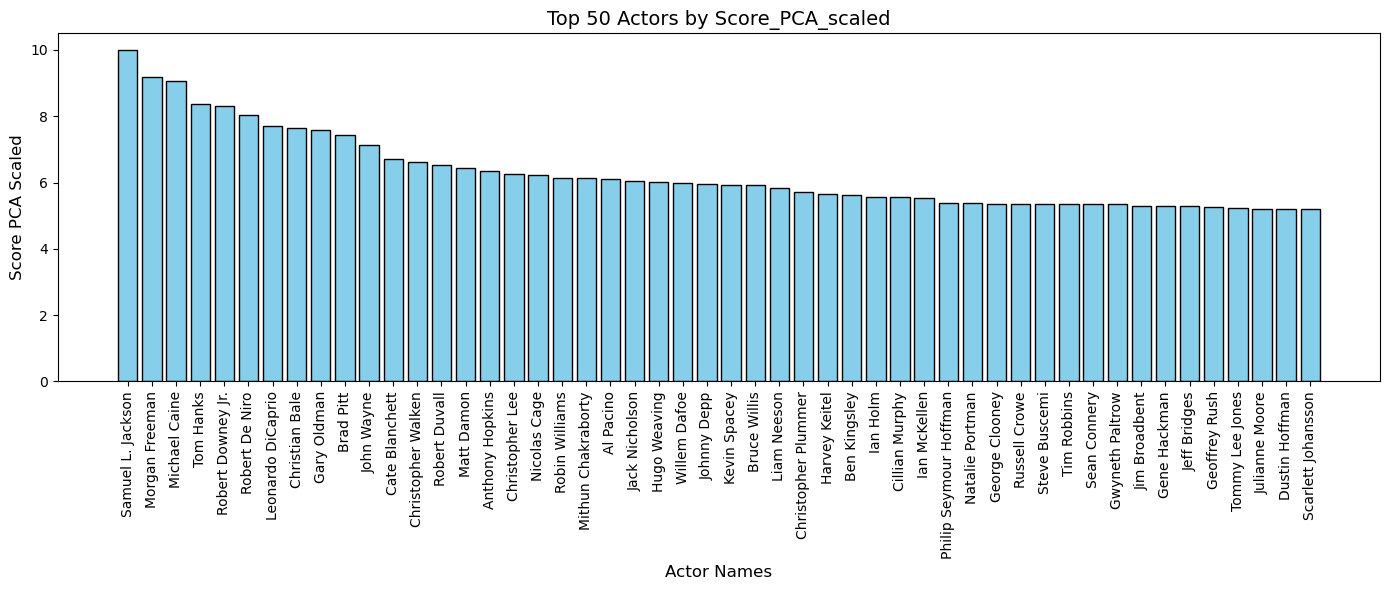

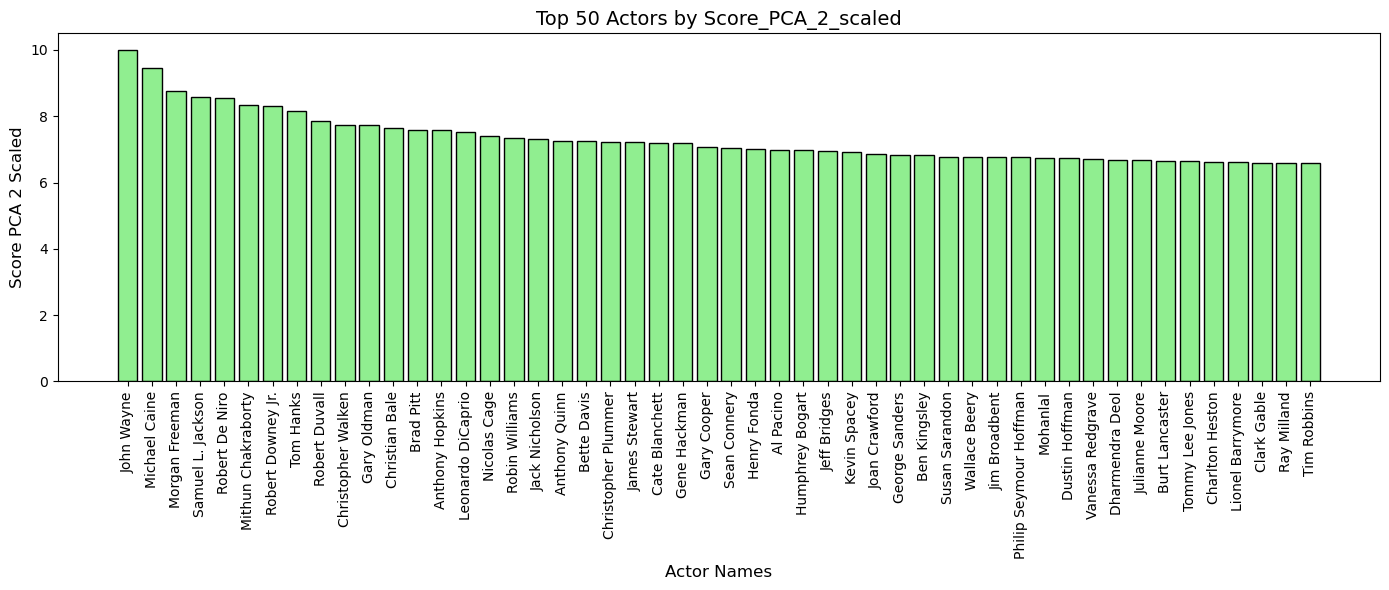

In [165]:
# Select the top 50 actors based on Score_PCA_scaled
top_50_pca_scaled = result_grouped.nlargest(50, 'Score_PCA_scaled')

# Plot for 'Score_PCA_scaled'
plt.figure(figsize=(14, 6))
plt.bar(top_50_pca_scaled['ActorName'], top_50_pca_scaled['Score_PCA_scaled'], color='skyblue', edgecolor='black')
plt.title('Top 50 Actors by Score_PCA_scaled', fontsize=14)
plt.xlabel('Actor Names', fontsize=12)
plt.ylabel('Score PCA Scaled', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

# Select the top 50 actors based on Score_PCA_2_scaled
top_50_pca_2_scaled = result_grouped.nlargest(50, 'Score_PCA_2_scaled')

# Plot for 'Score_PCA_2_scaled'
plt.figure(figsize=(14, 6))
plt.bar(top_50_pca_2_scaled['ActorName'], top_50_pca_2_scaled['Score_PCA_2_scaled'], color='lightgreen', edgecolor='black')
plt.title('Top 50 Actors by Score_PCA_2_scaled', fontsize=14)
plt.xlabel('Actor Names', fontsize=12)
plt.ylabel('Score PCA 2 Scaled', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


In [123]:
result_grouped

,ActorName,ActorDOB,ActorGender,ActorAgeAtRelease,Characters,primaryProfession,new_id,Countries,YearOfRelease,ratings,...,year_ceremony,Oscar,NumMovies,AvgRating,TotalVotes,OscarEncoded,Score_PCA,Score_PCA_2,Score_PCA_scaled,Score_PCA_2_scaled
0,'Big' Lee,1939,M,[nan],[Junkie in Casino],actor,[23010798],[United States of America],[1973],[5.7],...,NaN,nothing,1,5.700000,933.0,0.0,-0.514894,-0.312869,0.162052,1.007000
1,'Chicken' Holleman,None,None,[nan],[nan],None,[1873017],[United States of America],[1972],[6.0],...,NaN,nothing,1,6.000000,11281.0,0.0,-0.462133,-0.207589,0.175710,1.072612
2,'Evil' Ted Smith,None,None,[nan],[Ronnie],"art_department,actor,visual_effects","[3866200, tt7850334, tt16235342]","[United States of America,Japan, nan, nan]","[1991, 2019, 2022]","[4.9, 3.9, 4.3]",...,NaN,nothing,3,4.366667,8618.0,0.0,-0.461902,-0.675504,0.175769,0.781002
3,'Kecske' Molnár Levente,None,M,[nan],[Ovidiu],None,[31935934],"[France,Romania,Hungary]",[2010],[6.9],...,NaN,nothing,1,6.900000,1173.0,0.0,-0.355048,0.099682,0.203429,1.264107
4,'King Kong' Kashey,1903-11-28,M,[39.0],[Paj Mab's Guard #2],actor,[24051101],[United States of America],[1943],[4.5],...,NaN,nothing,1,4.500000,286.0,0.0,-0.675247,-0.725506,0.120545,0.749840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119222,都はるみ,1948-02-22,F,[35.0],[nan],None,[25896239],[Japan],[1983],[6.4],...,NaN,nothing,1,6.400000,77.0,0.0,-0.422890,-0.072421,0.185868,1.156850
119223,關淑怡,1966-08-15,F,"[26.0, 30.0]","[nan, nan]",None,"[26669413, 184987]","[Hong Kong, Hong Kong]","[1992, 1997]","[4.9, 7.7]",...,NaN,nothing,2,6.300000,35414.0,0.0,-0.281869,-0.052390,0.222372,1.169334
119224,陳文媛,1979-09-18,F,[23.0],[nan],None,[3059526],"[Thailand,Hong Kong]",[2003],[3.0],...,NaN,nothing,1,3.000000,387.0,0.0,-0.874555,-1.241112,0.068953,0.428509
119225,陳曉東,1975-09-03,M,"[22.0, 36.0]","[nan, nan]",None,"[7055021, 34430625]","[Hong Kong, Singapore]","[1998, 2012]","[6.1, 5.5]",...,NaN,nothing,2,5.800000,1404.0,0.0,-0.390659,-0.231346,0.194211,1.057807


In [167]:
# Function to flatten the list, split on commas, and exclude invalid values
def flatten_and_get_top_3(values_list):
    # Ensure that the input is not NaN or empty
    if values_list is None or (isinstance(values_list, float) and np.isnan(values_list)):
        return None
    
    if isinstance(values_list, list):
        # Flatten the list by splitting elements containing commas
        flat_list = []
        for value in values_list:
            if isinstance(value, str):  # Ensure each element is a string
                flat_list.extend(value.split(','))  # Split on commas and extend the flat list
        
        # Clean up whitespace and remove invalid entries
        flat_list = [x.strip() for x in flat_list if x.strip() not in ['', ' ']]
        
        # Count frequencies and get the top 3 most common elements
        counter = Counter(flat_list)
        top_3 = [item for item, _ in counter.most_common(3)]
        return top_3
    return None



# Apply the function to the Countries column
result_grouped['top_3_countries'] = result_grouped['Countries'].apply(flatten_and_get_top_3)
result_grouped['top_3_genre'] = result_grouped['Genres'].apply(flatten_and_get_top_3)



In [168]:
print(result_grouped.query('ActorName == "Morgan Freeman"')[['top_3_countries','top_3_genre']])

                                   top_3_countries               top_3_genre
80874  [United States of America, Germany, France]  [Drama, Thriller, Crime]


In [169]:
result_grouped.columns

Index(['ActorName', 'ActorDOB', 'ActorGender', 'ActorAgeAtRelease',
       'Characters', 'primaryProfession', 'new_id', 'Countries',
       'YearOfRelease', 'ratings', 'numVotes', 'Genres', 'Runtime',
       'year_ceremony', 'Oscar', 'NumMovies', 'AvgRating', 'TotalVotes',
       'OscarEncoded', 'Score_PCA', 'Score_PCA_2', 'Score_PCA_scaled',
       'Score_PCA_2_scaled', 'top_3_countries', 'top_3_genre',
       'socioeconomic_background', 'education_level',
       'early_life_opportunities', 'ActorHeight', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Goatee', 'Gray_Hair', 'High_Cheekbones',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Straight_Hair', 'Wavy_Hair', 'professionCategory'],
      dtype='object')

In [ ]:
result_grouped

In [170]:
result_grouped.to_pickle('final_actors_19_12_2024.pkl')


In [ ]:
merged_movies.to_pickle('movies_dataset_yc_3.pkl')

---
---
# Other sections down

---
---
## 2. Lylia's part

---
---
## 3. Ali's part

---
---
## 4. Christian's part

---
---
## 5. Network Analysis